In [4]:
import collections
import gensim
import heapq
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from matplotlib import offsetbox
from scipy.sparse import csr_matrix
from sklearn import cluster, datasets, decomposition, ensemble, lda, manifold, random_projection, grid_search
from sklearn.decomposition import TruncatedSVD
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from scipy import sparse as sp

%matplotlib inline

In [29]:
def write_evaluation(tuples, filename):
    f = open(filename, 'w+')
    f.write('Id,Prediction\n')
    for t in tuples:
        f.write(str(t[0]) + ',' + str(t[1]) + '\n')

In [27]:
def load_sparse_data(filename, num_lines):
    """
    Function to load sparse data.
    """
    inverted_index = collections.defaultdict(set)
    
    sparse_indptr = [0]
    sparse_indices = []
    sparse_data = []
    vocabulary = {}

    print 'Reading data.'
    for line_num, line in enumerate(open(filename)):
        new_row = [(idx,float(prob)) for idx, prob in enumerate(line.strip().split(',')) if float(prob) > 0.0]
        for i,p in new_row:
            sparse_indices.append(i)
            sparse_data.append(p)
            inverted_index[i].add(line_num)
        sparse_indptr.append(len(sparse_indices))

        if line_num % 450 == 0:
            print 100.0 * line_num / num_lines, '%'
    print 100.0 * line_num / num_lines, '%'
    print 'Done reading data.'

    sparse_matrix = csr_matrix((sparse_data, sparse_indices, sparse_indptr), dtype=float)
    return sparse_matrix, inverted_index

In [30]:
def sparse_where(sparse_matrix, num):
    """
    np.where() for a sparse matrix. Returns a set of indices.
    """
    return set(np.where(sparse_matrix[num,:].toarray())[1].tolist())

In [10]:
def load_clustering(fname):
    cluster_dict = {}
    cluster_inv_idx = collections.defaultdict(list)
    
    header = True
    actual_cluster_sizes = {}
    for line in open(fname):
        if header:
            header = False
            continue
        parts = line.strip().split(',')
        point = int(parts[0])
        cluster_num = int(parts[1])
        cluster_dict[point] = cluster_num
        cluster_inv_idx[cluster_num].append(point)
    
    return cluster_dict, cluster_inv_idx

# Load Data

In [14]:
NUM_SPEECHES = 2740
NUM_DEBATES = 38

In [54]:
speech_vectors, inverted_vectors = load_sparse_data('speech_vectors.csv', NUM_SPEECHES)

Reading data.
0.0 %
16.4233576642 %
32.8467153285 %
49.2700729927 %
65.6934306569 %
82.1167883212 %
98.5401459854 %
99.9635036496 %
Done reading data.


NameError: name 'sparse_data' is not defined

In [55]:
print speech_vectors.shape

(2740, 50000)


In [32]:
speech_graph, inverted_graph = load_sparse_data('speech_graph.csv', NUM_SPEECHES)
print speech_graph.shape

Reading data.
0.0 %
16.4233576642 %
32.8467153285 %
49.2700729927 %
65.6934306569 %
82.1167883212 %
98.5401459854 %
99.9635036496 %
Done reading data.
(2740, 2740)


In [195]:
predicted_label, predicted_label_inv_idx = load_clustering('hacky1.csv')

In [19]:
# Load ground truth for for/against labels.
for_against_label = {}

for_against_label_file = 'preds_laplacian1.csv'
header = True # Skip the header.
for row in open(for_against_label_file):
    if header:
        header = False
        continue
    
    entries = row.strip().split(',')
    speech_num = int(entries[0])
    label = entries[1]
    
    for_against_label[speech_num] = label

# Hints

### Actual cluster sizes

In [1]:
header = False
actual_cluster_sizes = {}
for line in open('challenge-2-label-hint.csv'):
    if header:
        header = False
        continue
    parts = line.strip().split(',')
    actual_cluster_sizes[int(parts[0])] = int(parts[1])

print actual_cluster_sizes
print len(actual_cluster_sizes)

{0: 327, 1: 294, 2: 282, 3: 159, 4: 134, 5: 130, 6: 117, 7: 114, 8: 89, 9: 87, 10: 84, 11: 64, 12: 60, 13: 58, 14: 58, 15: 54, 16: 53, 17: 45, 18: 44, 19: 43, 20: 42, 21: 42, 22: 42, 23: 41, 24: 35, 25: 30, 26: 28, 27: 27, 28: 26, 29: 21, 30: 20, 31: 19, 32: 17, 33: 14, 34: 14, 35: 12, 36: 11, 37: 3}
38


### Actual cluster seeds

In [196]:
header = False
actual_debates = {}
for line in open('actual-debate-labels.csv'):
    if header:
        header = False
        continue
    parts = line.strip().split(',')
    actual_debates[int(parts[1])] = int(parts[0])
    
for i in range(NUM_DEBATES):
    print i, '\t', actual_debates[i], '\t', actual_cluster_sizes[i]

0 	21 	327
1 	3 	294
2 	7 	282
3 	18 	159
4 	2 	134
5 	13 	130
6 	30 	117
7 	0 	114
8 	11 	89
9 	20 	87
10 	8 	84
11 	96 	64
12 	12 	60
13 	125 	58
14 	59 	58
15 	4 	54
16 	160 	53
17 	9 	45
18 	28 	44
19 	31 	43
20 	6 	42
21 	145 	42
22 	55 	42
23 	69 	41
24 	46 	35
25 	22 	30
26 	53 	28
27 	130 	27
28 	14 	26
29 	1 	21
30 	43 	20
31 	181 	19
32 	80 	17
33 	19 	14
34 	66 	14
35 	63 	12
36 	498 	11
37 	183 	3


# Evaluate the cluster sizes we found

In [197]:
print '#\tPred\tAct\tP-A'
print '==========================='
errors = 0
for i in range(NUM_DEBATES):
    pred = len(predicted_label_inv_idx[i])
    act = actual_cluster_sizes[i]
    errors += abs(pred-act)
    print i, '\t', pred,'\t', act, '\t', pred-act
print '# errors', errors

#	Pred	Act	P-A
0 	329 	327 	2
1 	295 	294 	1
2 	281 	282 	-1
3 	158 	159 	-1
4 	132 	134 	-2
5 	130 	130 	0
6 	118 	117 	1
7 	115 	114 	1
8 	87 	89 	-2
9 	87 	87 	0
10 	83 	84 	-1
11 	63 	64 	-1
12 	59 	60 	-1
13 	57 	58 	-1
14 	59 	58 	1
15 	54 	54 	0
16 	50 	53 	-3
17 	45 	45 	0
18 	47 	44 	3
19 	43 	43 	0
20 	42 	42 	0
21 	42 	42 	0
22 	42 	42 	0
23 	41 	41 	0
24 	36 	35 	1
25 	30 	30 	0
26 	29 	28 	1
27 	26 	27 	-1
28 	25 	26 	-1
29 	21 	21 	0
30 	21 	20 	1
31 	20 	19 	1
32 	17 	17 	0
33 	14 	14 	0
34 	17 	14 	3
35 	7 	12 	-5
36 	12 	11 	1
37 	6 	3 	3
# errors 40


# Fix clusters -

In [115]:
remaining_set = set()
for i in range(6, 9):
    remaining_set = remaining_set.union(set(predicted_label_inv_idx[i]))
    
print len(remaining_set)

remaining = sorted(list(remaining_set))

speech_graph_copy, _ = load_sparse_data('speech_graph.csv', NUM_SPEECHES)

# Create affinity matrix.
print 'Creating affinity matrix.'
for row in range(NUM_SPEECHES):
    row_indices = sparse_where(speech_graph, row)
    for index in row_indices:
        # Remove connections to points we have already labeled.
        # Remove connections to debate with the same label.
        if index not in remaining_set or for_against_label[row] == for_against_label[index]:
            speech_graph_copy[row, index] = 0.0
    if row % 450 == 0:
        print row * 100.0 / NUM_SPEECHES, '%'

print 'Done'

320
Reading data.
0.0 %
16.4233576642 %
32.8467153285 %
49.2700729927 %
65.6934306569 %
82.1167883212 %
98.5401459854 %
99.9635036496 %
Done reading data.
Creating affinity matrix.
0.0 %
16.4233576642 %
32.8467153285 %
49.2700729927 %
65.6934306569 %
82.1167883212 %
98.5401459854 %
Done


In [116]:
speech_graph_copy_trimmed = speech_graph[sorted(remaining),:]
print speech_graph_copy_trimmed.shape
speech_graph_copy_trimmed = speech_graph_copy_trimmed[:,sorted(remaining)]
print speech_graph_copy_trimmed.shape

(320, 2740)
(320, 320)


[42, 59, 43, 41, 32, 45, 58]
[(1, 30), (5, 0), (2, 11)]


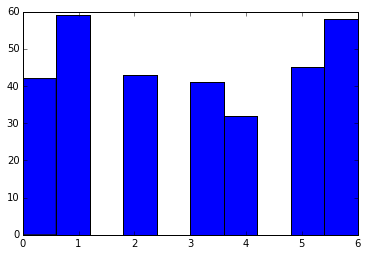

In [124]:
n_clusters = 7
spectral_labels = cluster.spectral_clustering(speech_graph_copy_trimmed, n_clusters=n_clusters)
plt.hist(spectral_labels, bins=10)
print [list(spectral_labels).count(i) for i in range(n_clusters)]
print [(spectral_labels[remaining.index(i)],i) for i in actual_debates.values() if i in remaining_set]

In [175]:
to_relabel = set()

In [176]:
speech_vectors_trimmed = speech_vectors[sorted(predicted_label_inv_idx[0]),:]
speech_vectors_trimmed = speech_vectors_trimmed[:,sorted(predicted_label_inv_idx[0])]
pca_model = decomposition.PCA(n_components=5)
pca_data = pca_model.fit_transform(speech_vectors_trimmed.toarray())

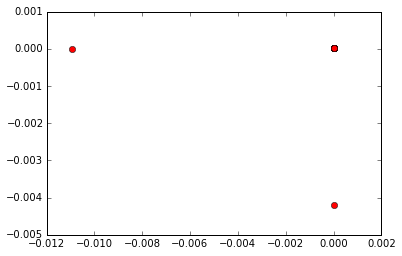

In [177]:
plt.plot(pca_data[:,0], pca_data[:,1], 'ro')

In [178]:
print sum(1 for i in range(len(remaining_set)) if pca_data[i,0] < -0.002 or pca_data[i,1] < -0.002)

2


In [179]:
new_relabels = [sorted(predicted_label_inv_idx[0])[i] for i in range(len(remaining_set)) if pca_data[i,0] < -0.002 or pca_data[i,1] < -0.002]
to_relabel = to_relabel.union(new_relabels)
for i in new_relabels:
    predicted_label_inv_idx[0].remove(i)

In [180]:
print to_relabel
print len(to_relabel)
print sum([1 for i in to_relabel if i in actual_debates.values()])

set([2369, 469])
2
0


## C 1

In [181]:
CLUSTER_NUM = 1

next_cand = sorted(predicted_label_inv_idx[CLUSTER_NUM])
next_cand.extend(list(to_relabel))

speech_vectors_trimmed = speech_vectors[sorted(next_cand),:]
speech_vectors_trimmed = speech_vectors_trimmed[:,sorted(next_cand)]

pca_model = decomposition.PCA(n_components=5)
pca_data = pca_model.fit_transform(speech_vectors_trimmed.toarray())

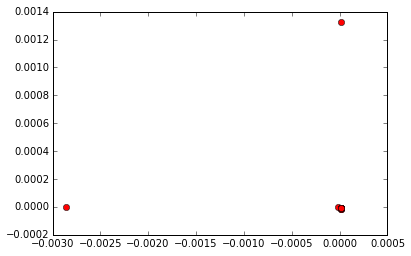

In [193]:
plt.plot(pca_data[:,1], pca_data[:,2], 'ro')

In [194]:
errs = sum(1 for i in range(len(next_cand)) if pca_data[i,1] < -0.0005 or pca_data[i,2] > 0.001)
print errs
print len(next_cand) - errs

2
283


In [184]:
new_relabels = [sorted(next_cand)[i] for i in range(len(next_cand)) if pca_data[i,0] < -0.001 or pca_data[i,1] < -0.001]
to_relabel = new_relabels
for i in new_relabels:
    try:
        predicted_label_inv_idx[CLUSTER_NUM].remove(i)
    except:
        pass
print len(to_relabel)
print len( predicted_label_inv_idx[CLUSTER_NUM])

4
291


## C 2

In [186]:
CLUSTER_NUM = 2

next_cand = sorted(predicted_label_inv_idx[CLUSTER_NUM])
next_cand.extend(list(to_relabel))

speech_vectors_trimmed = speech_vectors[sorted(next_cand),:]
speech_vectors_trimmed = speech_vectors_trimmed[:,sorted(next_cand)]

pca_model = decomposition.PCA(n_components=5)
pca_data = pca_model.fit_transform(speech_vectors_trimmed.toarray())

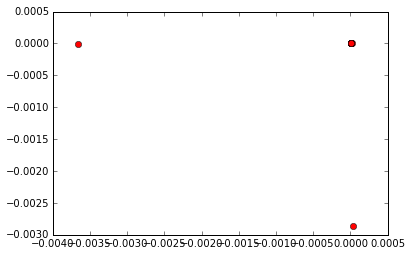

In [187]:
plt.plot(pca_data[:,0], pca_data[:,1], 'ro')

In [189]:
errs = [i for i in range(len(next_cand)) if pca_data[i,0] < -0.0015 or pca_data[i,1] < -0.001]
print len(errs)
print len(next_cand) - len(errs)

2
283


In [ ]:
write_evaluation([(i, d[i]) for i in range(NUM_SPEECHES)], 'fix.csv')